In [1]:
# Load required Libraries
import numpy as np, pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import r2_score # To get the rsq score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
#from sklearn.utils import check_arrays  # For MAPE calculation
from sklearn.preprocessing import PolynomialFeatures #For Polynomial LM
from sklearn.model_selection import cross_val_score #K-fold CV
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format  # to suppress scientific notation

# -------------------Data Loading and Pre-processing-----------------------

In [2]:
# Read The data and get the overview
df = pd.read_csv("D:/Notes/Matt 891/Matt_imdb project/Web_Scrape_data.csv")
print(df.info()) # Summary of the data
print("------------------------------------------------")
print(df.head()) # small Part of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 11 columns):
title                         1732 non-null object
year                          1732 non-null object
certi                         1723 non-null object
time                          1723 non-null object
release_date                  1732 non-null object
rating                        1732 non-null float64
metascore                     1732 non-null object
budget                        1732 non-null object
Opening_Weekend_USA           1732 non-null object
Gross_USA                     1732 non-null object
Cumulative_Worldwide_Gross    1732 non-null object
dtypes: float64(1), object(10)
memory usage: 149.0+ KB
None
------------------------------------------------
                                              title  year  certi      time  \
0                                    Avatar (2009)   2009  PG-13  2h 42min   
1  Pirates of the Caribbean: At World's End (2007)   2007  PG-13  

In [3]:
# Data Cleaning
    # 1.Select movies released on and after the year 2000, this will help us reduce the effect of inflation. 
          #Remove observations with "-" in title, grossUSA and budget. 
    # 2. Remove "," and "$" characters from the financial columns.
    # 3. There are multiple "-" in the data in multiple column. We need to remove then in colums ment to be of type-int.
    # 4. Convert Time into mins.

# 1--------------------
df = df[df.title != "-"]     # Removing obs with "-" in it as the whole row for that obs has no data.
df = df[df.budget != "-"]    # Removing obs with "-" in it as Budget and Gross_USA is suspected to be a key variable to predict.
df = df[df.Gross_USA != "-"]   

df["year"] = pd.to_numeric(df["year"])    # Converting to numeric as to apply the filter 
df = df[df.year >= 2000]               #   and select movies released in and after 2000

# 2--------------------
# Cleaning these colums as we want them to be quantitative variables.
cols_to_check = ['rating','metascore','budget','Opening_Weekend_USA', 'Gross_USA','Cumulative_Worldwide_Gross']
df[cols_to_check] = df[cols_to_check].replace({',':''}, regex=True)
df[cols_to_check] = df[cols_to_check].replace({'\$':''}, regex=True)
df[cols_to_check] = df[cols_to_check].replace({'-':''}, regex=True)

# 3--------------------
# Converting variables to integer types 

df["rating"] = pd.to_numeric(df["rating"])
df["metascore"] = pd.to_numeric(df["metascore"])
df["budget"] = pd.to_numeric(df["budget"])
df["Opening_Weekend_USA"] = pd.to_numeric(df["Opening_Weekend_USA"])
df["Gross_USA"] = pd.to_numeric(df["Gross_USA"])
df["Cumulative_Worldwide_Gross"] = pd.to_numeric(df["Cumulative_Worldwide_Gross"])

# 4--------------------
# Converting the duration of movies from hr,min fromat to mins and then placing them as numeric form.
            # eg: "1h 48min" --> 108

Runtime = list()
for i in range(len(df)):  # Itterating through all the "time" elements to convert them
    try:
        t = df.iloc[i, 3]
        l_t = t.split()
        l_t[0]= l_t[0].replace('h','')
        l_t[1]= l_t[1].replace('min','')
        a = (int(l_t[0])*60) + int(l_t[1])
        Runtime.append(a)
    except:
        Runtime.append("-")
        
df["Runtime"] = Runtime
df["Runtime"] = df["Runtime"].replace({'-':''}, regex=True)
df["Runtime"] = pd.to_numeric(df["Runtime"])      # Changing Runtime to int type

print(df.info()) # Summary of the data
print("------------------------------------------------")
print(df.head()) # small Part of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093 entries, 0 to 1731
Data columns (total 12 columns):
title                         1093 non-null object
year                          1093 non-null int64
certi                         1093 non-null object
time                          1093 non-null object
release_date                  1093 non-null object
rating                        1093 non-null float64
metascore                     790 non-null float64
budget                        1093 non-null int64
Opening_Weekend_USA           1092 non-null float64
Gross_USA                     1093 non-null int64
Cumulative_Worldwide_Gross    1093 non-null int64
Runtime                       1079 non-null float64
dtypes: float64(4), int64(4), object(4)
memory usage: 151.0+ KB
None
------------------------------------------------
                                              title  year  certi      time  \
0                                    Avatar (2009)   2009  PG-13  2h 42min   
1  Pirat

# ---------------------------Exploring the data-----------------------------------------

### We will be understanding, processing and cleaning the data based on our findings

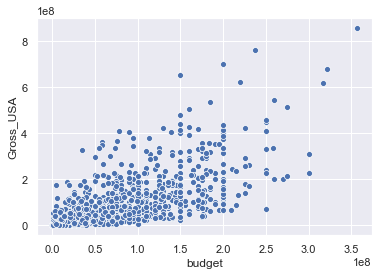

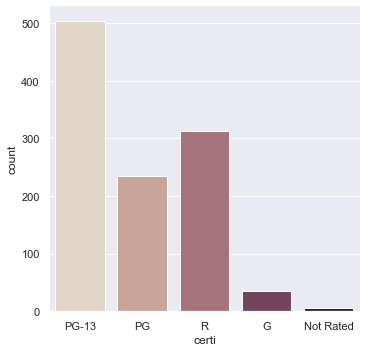

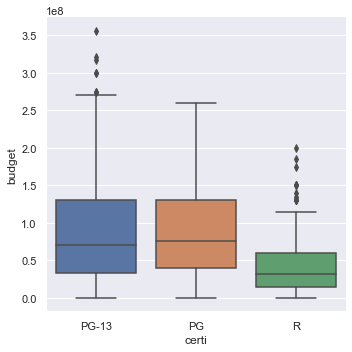

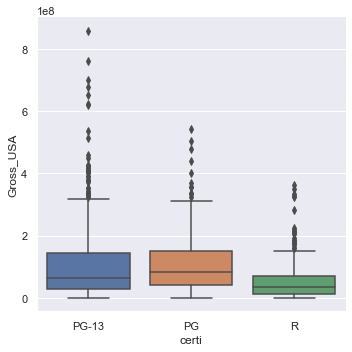

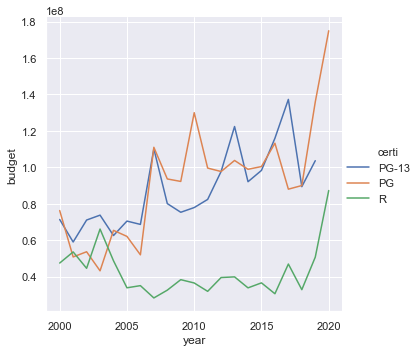

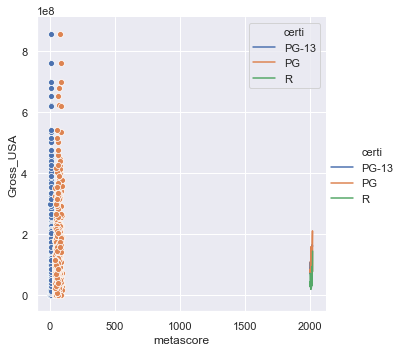

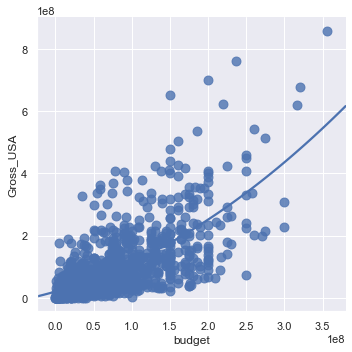

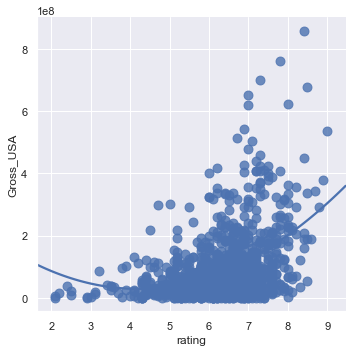

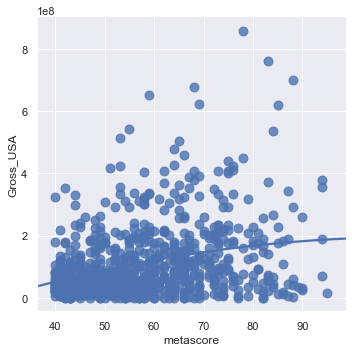

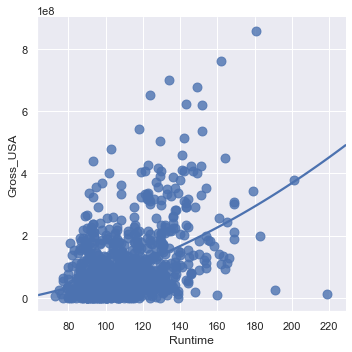

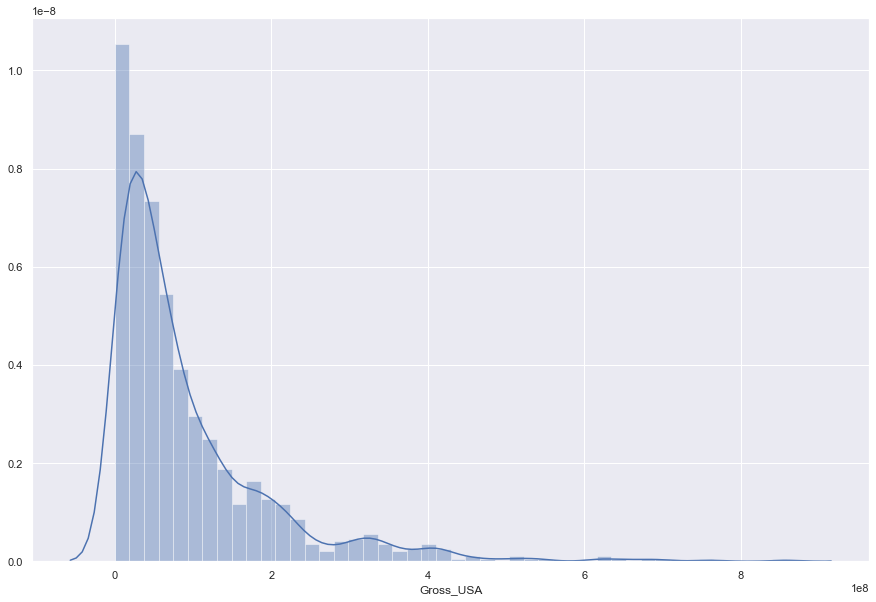

In [4]:
p1 = sns.scatterplot(x="budget", y="Gross_USA", data=df)  ## To observe Relationship between the variable budget and Gross_USA

p2 = sns.catplot(x="certi", kind="count", palette="ch:.25", data=df) ## Check distribution of movies accross different certification categories
# we can see that from the above chart that certifications "G" and "Not rated" amount for 40 count out of total observations.
                                                        #Thus we can exclude it as it forms just 4% of the data. 
df = df[df.certi != "Not Rated"]
df = df[df.certi != "G"]

# To check for outliers and understand the range of data colums
df["year"] = df["year"].astype('category',copy=False)
p3 = sns.catplot(x="certi", y="budget", kind="box", data=df)
p4 = sns.catplot(x="certi", y="Gross_USA", kind="box", data=df)
p5 = sns.relplot(x="year", y="budget", hue="certi",
            dashes=False, markers=True, ci=None, kind="line", data=df)
p6 = sns.relplot(x="year", y="Gross_USA", hue="certi",
            dashes=False, markers=True, ci=None, kind="line", data=df)

# we will be checking for gross_USA vs rating and metascore as there seems to be a relationship
p7 = sns.scatterplot(x="rating", y="Gross_USA", data=df)

p8 = sns.scatterplot(x="metascore", y="Gross_USA", data=df)

# to check if variables have linear relationship with Gross_USA or not
p9 = sns.lmplot(x="budget", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p10 = sns.lmplot(x="rating", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p11 = sns.lmplot(x="metascore", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p12 = sns.lmplot(x="Runtime", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})

# Distribution of Gross_USA
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df['Gross_USA'])

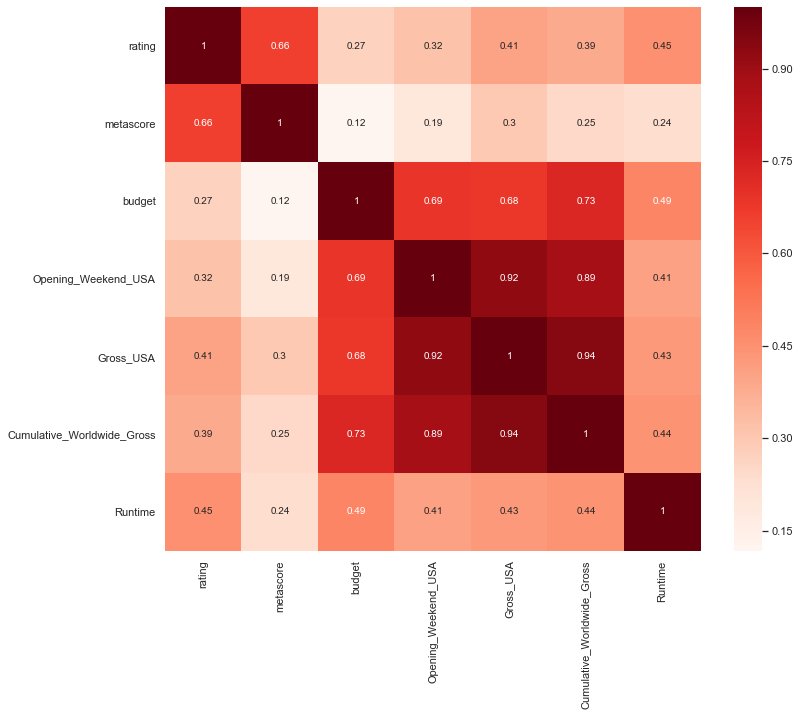

In [5]:
# Creating a corelation matrix of quantitative variables to understand how strong the variables are related with each other.
#df["year"] = pd.to_numeric(df["year"])
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### we can see that Opening_Weekend_USA and cumulative_Worldwide_gross have exceptionally high corelation value. This might create the effect of multicolinearity in the model. With help of some business understanding it is clear to us that Opening_Weekend_USA is part of Gross_USA and Gross_USA is part of cumulative_Worldwide_gross. Thus these are essentially categories of outcome variable and hence can be neglected.

### For other variables, 

In [6]:
#df.to_csv("D:/Notes/Matt 891/Matt_imdb project/IMDBforR.csv")

# ------------------------------Creating a Baseline Linear Model------------------------

In [17]:
# Get a Overview of the data
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 1731
Data columns (total 12 columns):
title                         1052 non-null object
year                          1052 non-null category
certi                         1052 non-null object
time                          1052 non-null object
release_date                  1052 non-null object
rating                        1052 non-null float64
metascore                     758 non-null float64
budget                        1052 non-null int64
Opening_Weekend_USA           1051 non-null float64
Gross_USA                     1052 non-null int64
Cumulative_Worldwide_Gross    1052 non-null int64
Runtime                       1038 non-null float64
dtypes: category(1), float64(4), int64(3), object(4)
memory usage: 140.4+ KB
None
       rating  metascore       budget  Opening_Weekend_USA    Gross_USA  \
count 1052.00     758.00      1052.00              1051.00      1052.00   
mean     6.27      58.18  73710743.35          

In [18]:
#Correlation with output variable. Selecting variables based on corelation matrix

cor_target = abs(cor["Gross_USA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25 ]
relevant_features = relevant_features[relevant_features<0.9 ]
relevant_features

rating      0.41
metascore   0.30
budget      0.68
Runtime     0.43
Name: Gross_USA, dtype: float64

In [19]:
df["year"] = df["year"].astype('category',copy=False)

# Checking for null values and filling it with the mean of the colum for only those which we are going to check as independent variables 
df.isnull().any()
df['metascore'].fillna((df['metascore'].mean()), inplace=True)
df['Runtime'].fillna((df['Runtime'].mean()), inplace=True)

# Selecting the colums for analysis and Converting categorical variable to dummy 

df_model = df[['certi', 'rating', 'metascore', 'budget', 'Runtime','Gross_USA','year']]
df_model = pd.get_dummies(df_model)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052 entries, 0 to 1731
Data columns (total 29 columns):
rating         1052 non-null float64
metascore      1052 non-null float64
budget         1052 non-null int64
Runtime        1052 non-null float64
Gross_USA      1052 non-null int64
certi_PG       1052 non-null uint8
certi_PG-13    1052 non-null uint8
certi_R        1052 non-null uint8
year_2000      1052 non-null uint8
year_2001      1052 non-null uint8
year_2002      1052 non-null uint8
year_2003      1052 non-null uint8
year_2004      1052 non-null uint8
year_2005      1052 non-null uint8
year_2006      1052 non-null uint8
year_2007      1052 non-null uint8
year_2008      1052 non-null uint8
year_2009      1052 non-null uint8
year_2010      1052 non-null uint8
year_2011      1052 non-null uint8
year_2012      1052 non-null uint8
year_2013      1052 non-null uint8
year_2014      1052 non-null uint8
year_2015      1052 non-null uint8
year_2016      1052 non-null uint8
year_2017   

In [54]:
# Selecting variables to run a LM using Stats Model.

X = df_model[['budget', 'Runtime','certi_PG','certi_PG-13','certi_R','year_2000','year_2001','year_2002','year_2003',
             'year_2004','year_2005','year_2006','year_2007','year_2008','year_2009','year_2010','year_2011','year_2012',
             'year_2013','year_2014','year_2015','year_2016','year_2017','year_2018','year_2019','year_2020']].values
y = df_model[["Gross_USA"]].values


mod = sm.OLS(y,X)

fii = mod.fit()

p_values = fii.summary2().tables[1]['P>|t|']
p_values


x1    0.00
x2    0.00
x3    0.00
x4    0.00
x5    0.00
x6    0.03
x7    0.13
x8    0.64
x9    0.07
x10   0.38
x11   0.07
x12   0.11
x13   0.34
x14   0.15
x15   0.70
x16   0.08
x17   0.01
x18   0.63
x19   0.03
x20   0.30
x21   0.46
x22   0.03
x23   0.37
x24   0.02
x25   0.05
x26   0.55
Name: P>|t|, dtype: float64

In [40]:
# Reducing the number of variables observing the p-value

X1 = df_model[['budget', 'Runtime','certi_PG','certi_PG-13','certi_R','year_2000',
             'year_2004','year_2009','year_2010','year_2012',
             'year_2015','year_2017','year_2018','year_2019']].values
y1 = df_model[["Gross_USA"]].values

regressor1 = LinearRegression()  
regressor1.fit(X1,y1)

coeff_df1 = pd.DataFrame.from_records(regressor1.coef_)
coeff_df1

y_pred1 = regressor1.predict(X1)
df_comp1 = pd.DataFrame({'Actual': y1[:,0], 'Predicted': y_pred1[:,0]})
df_1 = df_comp1.head(25)

score1 = r2_score(y1, y_pred1) 
score1

0.496966838781579

# Validation Method

In [48]:
#Our next step is to divide the data into “attributes” and “labels”. 
#X variable contains all the attributes/features and y variable contains labels.


#Next, we split 70% of the data to the training set while 30% of the data to test set using below code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Now lets Train our Model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# Lets see the coefficients our regression model has chosen:

#coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df = pd.DataFrame.from_records(regressor.coef_)
#coeff_df.columns = ['year', 'budget', 'Runtime','certi_PG','certi_PG-13','certi_R']
coeff_df = pd.DataFrame.from_records(regressor.coef_)


In [49]:
# Prediction
y_pred = regressor.predict(X_test)
df_comp = pd.DataFrame({'Actual': y_test[:,0], 'Predicted': y_pred[:,0]})
df1 = df_comp.head(25)
#df1

In [50]:
# Function to calculate MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
mean_absolute_percentage_error(y_test, y_pred)  ## Calculate MAEP

1753.5103757894099

In [52]:
# Performace
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
score = r2_score(y_test, y_pred) 
score

Mean Absolute Error: 54568653.87123704
Mean Squared Error: 6684638214053232.0
Root Mean Squared Error: 81759636.82681835


0.4532912209282992

# -------------10-fold Cross Validation-------------

In [32]:
regressor10 = LinearRegression() 
scores = cross_val_score(regressor10, X1, y1, cv=10)
print(scores)

[ 0.17123931  0.15175065 -0.11453565 -0.15869307  0.64136782  0.21340989
  0.2824999   0.15365999  0.52551305  0.44069508]


# ---------------------( Feature Elimination)-----------------------

In [ ]:
graph = sns.lmplot('budget', 'Gross_USA', data = df, fit_reg=True, order=1)


In [ ]:
# https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/


# RFE
# create a base classifier used to evaluate a subset of attributes
model2 = LinearRegression()
# create the RFE model and select 3 attributes
rfe = RFE(regressor1, 8)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)


In [ ]:
X2 = df_model[['budget', 'Runtime','certi_PG','certi_PG-13','certi_R',
               'year_2017','year_2018','year_2019','year_2020','year_2005','year_2006','year_2009']].values
y2 = df_model[["Gross_USA"]].values


X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

# Now lets Train our Model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [ ]:
score = r2_score(y_test, y_pred) 
out = mean_absolute_percentage_error(y_test, y_pred)
out

# ------------ Polynomial LM-----------------

In [ ]:
#https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

In [36]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X)

model_p = LinearRegression()
model_p.fit(x_poly, y)
y_poly_pred = model_p.predict(x_poly)

r2 = r2_score(y,y_poly_pred)
print(r2)

0.5342463963271922


In [37]:
out = mean_absolute_percentage_error(y, y_poly_pred)
out

2838.953837275197

# --------------------Logistic Regression-------------------------

,title,year,certi,time,release_date,rating,metascore,budget,Opening_Weekend_USA,Gross_USA,Cumulative_Worldwide_Gross,Runtime
0,Avatar (2009),2009,PG-13,2h 42min,18 December 2009 (USA),7.80,83.00,237000000,77025481.00,760507625,2790439000,162.00
1,Pirates of the Caribbean: At World's End (2007),2007,PG-13,2h 49min,25 May 2007 (USA),7.10,50.00,300000000,114732820.00,309420425,960996492,169.00
2,The Dark Knight Rises (2012),2012,PG-13,2h 44min,20 July 2012 (USA),8.40,78.00,250000000,160887295.00,448139099,1081041287,164.00
3,John Carter (2012),2012,PG-13,2h 12min,9 March 2012 (USA),6.60,51.00,250000000,30180188.00,73078100,284139100,132.00
4,Spider-Man 3 (2007),2007,PG-13,2h 19min,4 May 2007 (USA),6.20,59.00,258000000,151116516.00,336530303,894983373,139.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1727,Angel Has Fallen (2019),2019,R,2h 1min,23 August 2019 (USA),6.40,45.00,40000000,21380987.00,69030436,147501990,121.00
1728,1917 (2019),2019,R,1h 59min,10 January 2020 (USA),8.40,78.00,95000000,576216.00,159227644,368027644,119.00
1729,Dolittle (2020),2020,PG,1h 41min,17 January 2020 (USA),5.60,58.18,175000000,21844045.00,77047065,223343452,101.00
1730,Bad Boys For Life (2020),2020,R,2h 4min,17 January 2020 (USA),6.80,59.00,90000000,62504105.00,204417855,419074646,124.00


In [6]:
#-------------------------------- log scaling----------------------

In [14]:
data = df[['budget','Gross_USA']]
data['Gross_USA'] = np.log10(data['Gross_USA'])

C:\Users\neilr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


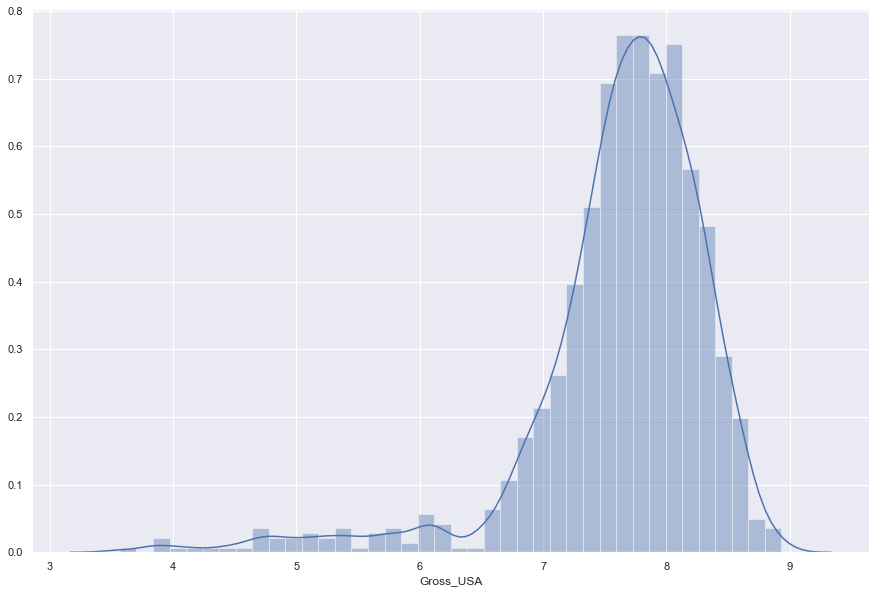

In [15]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(data['Gross_USA'])